In [1]:
import os, pathlib
os.chdir("/Users/gregcc/Documents/GitHub/SURP25/Microlensing")

In [2]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from ML import TwoLens1S
from ML import ThreeLens1S

## Set Up of "Standard" System

In [3]:
m1 = 0.3 #Lens Star Mass (Solar Mass)
m2 = 0.0002857 #Lens Planet Mass (Saturn Mass in Solar Mass)
m3 = 3.003e-6 #Lens Moon (Earth Mass in Solas Mass)

m3 = m3 * 0.5

M_total = m1 + m2+ m3

D_l = 7.59 #kpc
D_s = 8.55 #kpc

s2 = 1.3 #R_E (Star-Planet Separation)
s3 = 0.01 #R_E (Planet-Moon Separation)

q2 = m2/m1
q3 = m3/m1
print(q2, q3, m3/m1)

# Event parameters
t0 = 0
tE = 20
rho = 0.001
rs = rho
u0_list = [0.1]


secnum = 45
basenum = 2
num_points = 1000

0.0009523333333333334 5.005e-06 5.005e-06


In [4]:
q3=m3/m1
print(q3)

5.005e-06


In [5]:
def Einstein_Radius(M_solar, D_l_kpc, D_s_kpc):
    """
    Computes the Einstein Radius.

    Parameters:
    M_solar : float
        Mass of the lens in Solar masses
    D_l_kpc : float
        Distance to the lens in kpc
    D_s_kpc : float
        Distance to the source in kpc

    Returns:
    R_E : float
        Einstein radius in meters
    theta_E_arcsec : float
        Einstein radius in arcseconds
    theta_E_mas : float
        Einstein radius in milliarcseconds
    """
    # Constants
    c = 3e8            # speed of light in m/s
    G = 6.674e-11      # gravitational constant in N m^2 / kg^2
    M_sun = 1.989e30   # kg
    kpc_to_m = 3.086e19  # meters
    rad_to_arcsec = 206265  # arcsec per radian

    # Convert inputs
    M = M_solar * M_sun
    D_l = D_l_kpc * kpc_to_m
    D_s = D_s_kpc * kpc_to_m
    D_ls = D_s - D_l

    # Einstein radius in meters
    R_E = ((4 * G * M / c**2) * (D_ls * D_l / D_s)) ** 0.5

    # Angular Einstein radius in radians
    theta_E_rad = R_E / D_l

    # Convert to arcsec and mas
    theta_E_arcsec = theta_E_rad * rad_to_arcsec
    theta_E_mas = theta_E_arcsec * 1000

    return R_E, theta_E_arcsec, theta_E_mas


In [6]:
R_E, theta_E_arcsec, theta_E_mas = Einstein_Radius(M_total, D_l, D_s)

print(f"Einstein Radius: {R_E:.2e} m")
print(f"Angular Einstein Radius: {theta_E_arcsec:.4f} arcsec")
print(f"Angular Einstein Radius: {theta_E_mas:.2f} mas")

Einstein Radius: 2.16e+11 m
Angular Einstein Radius: 0.0002 arcsec
Angular Einstein Radius: 0.19 mas


In [7]:
tau_lc = np.linspace(-4, 4, 1000)
t_lc = t0 + tau_lc * tE

In [8]:
double_model = TwoLens1S(t0, tE, rho, u0_list, q2, s2, 25, t_lc)

In [9]:
double_model_tau = double_model.tau_lc
double_model_mag = double_model.systems[0]["mag"]

In [ ]:
triple_model = ThreeLens1S(t0, tE, rho, u0_list, q2, q3, s2, s3, 25, 15, rs, secnum, basenum, num_points)

param = [
    np.log(triple_model.s2), np.log(triple_model.q2), triple_model.u0_list[0], triple_model.alpha_deg,
    np.log(triple_model.rho), np.log(triple_model.tE), triple_model.t0,
    np.log(triple_model.s3), np.log(triple_model.q3), triple_model.psi_rad
]
mag, *_ = triple_model.VBM.TripleLightCurve(param, triple_model.highres_t)

# now you have
triple_model_tau = triple_model.highres_tau
triple_model_mag = mag

In [ ]:
np.savez("triple_lightcurve_data2.npz",
         tau=triple_model_tau,
         mag=triple_model_mag)

In [ ]:
#triple_model.animate()

In [ ]:
data = np.load("triple_lightcurve_data2.npz")
triple_model_tau = data['tau']
triple_model_mag = data['mag']

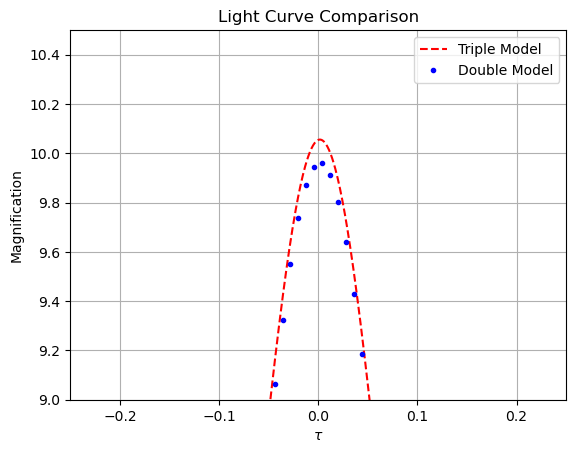

In [ ]:
plt.plot(triple_model_tau, triple_model_mag, '--', label = "Triple Model", color = 'red')
plt.plot(double_model_tau, double_model_mag, '.b', label="Double Model")

plt.xlim(-.25, .25)
plt.ylim(9, 10.5)

plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.title("Light Curve Comparison")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
two_system = double_model.systems[0]
three_system = triple_model.systems[0]

# Differences relative to source
delta_x_two = two_system['cent_x_hr'] - two_system['x_src_hr']
delta_y_two = two_system['cent_y_hr'] - two_system['y_src_hr']

delta_x_three = three_system['cent_x'] - three_system['y1s']
delta_y_three = three_system['cent_y'] - three_system['y2s']

delta_x_three = - delta_x_three
delta_y_three = delta_y_three

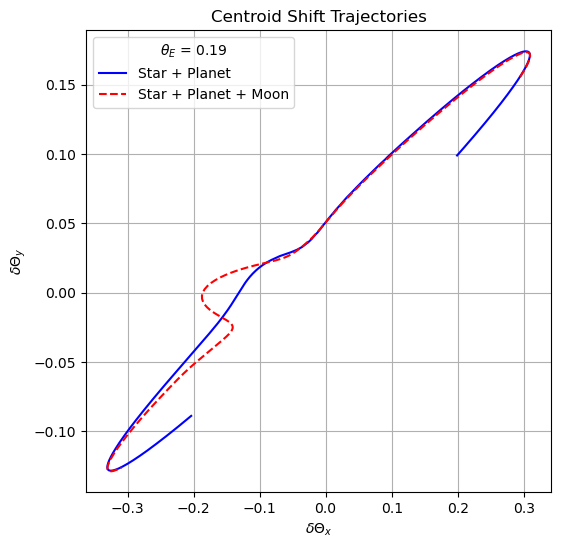

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(delta_x_two, delta_y_two, 'b-', label='Star + Planet')
plt.plot(delta_x_three, delta_y_three, 'r--', label='Star + Planet + Moon')
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)
plt.legend(title=fr"$\theta_E$ = {theta_E_mas:.2f}")
plt.show()

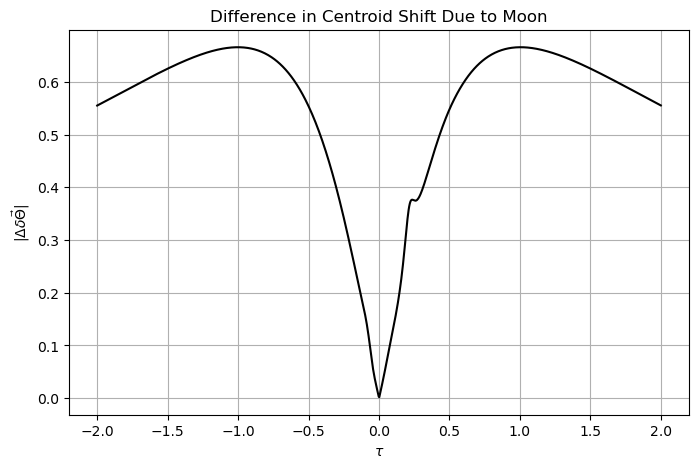

In [ ]:
residual_shift = np.sqrt( (delta_x_three - delta_x_two)**2 + (delta_y_three - delta_y_two)**2 )

plt.figure(figsize=(8,5))
plt.plot(triple_model.tau, residual_shift, 'k')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$|\Delta \delta \vec{\Theta}|$")
plt.title("Difference in Centroid Shift Due to Moon")
plt.grid(True)
plt.show()

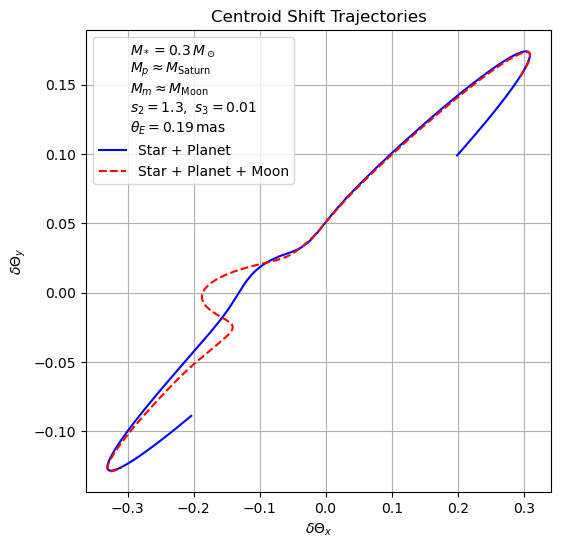

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(delta_x_two, delta_y_two, 'b-', label='Star + Planet')
plt.plot(delta_x_three, delta_y_three, 'r--', label='Star + Planet + Moon')
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)

setup_str = (
    r"$M_*=0.3\,M_\odot$" + "\n"
    r"$M_p\approx M_{\rm Saturn}$" + "\n"
    r"$M_m\approx M_{\rm Moon}$" + "\n"
    r"$s_2=1.3,\ s_3=0.01$" + "\n"
    rf"$\theta_E = {theta_E_mas:.2f}\,{{\rm mas}}$"
)
plt.legend(title=setup_str)


plt.show()


SyntaxError: invalid syntax (794112302.py, line 1)